# 3: Streams 

In [1]:
# Essential - general
import numpy as np
import matplotlib.pyplot as plt

# Essential - astro
import astropy.units as u
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# Style
import matplotlib as mpl
import matplotlib.cm as cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams.update({'font.size': 25})

### 3.1: Streams in a spherical potential  

In this notebook we will analyze the evolution of stellar systems like globular clusters and other satellites in Milky Way like galaxies. We will assume that the mock satellite *magically* becomes gravitationally unbound once it is launched on some initial orbit. 

For simplicty we will generate mock stellar systems from a normal distribution - for extra kudos you can use the self-consistent Plummer systems from Notebook 2!

Insert a particle at the centre of the system, i.e. located at (x,v) = (0,0) [kpc, km/s]. Next put the system on the orbit specified below and integrate the system (i.e. the 10$^4$ + 1 particles) for 5 Gyr in an Milky Way potential (i.e. the gala `gala.potential.MilkyWayPotential`).


- Plot the spatial evolution of the system in two planes (e.g. (x,y) and (x,z)) and at various times (e.g. 1, 2, ..., 5 Gyr)  
- Comment on the behaviour of the particles as time goes by. What do you see happens? Can you explain qualitatively the reason for the behaviour observed?
- What are the differences in the behaviour between the orbits? 
- How would you explain the differing behaviours?
- Colour the particles by the orbital energy and discuss the results. What is the energy of the leading arm relative to the central particle? And what about the trailing arm?
- Take the central particle and one random other particle and calculate the evolution of their separation $r(t) = |\vec{x_1} - \vec{x_2}|$. What do you find? How does this depend on the orbits?
- What happens if you change the size of the initial distribution?

Hint 1: gala can compute the orbital energy using `orbit.energy()`.  \
Hint 2: overplot the central orbit on the spatial evolution and use it to explain what you see. Is the stream always aligned with this, why or why not?     \
Hint 3: Orbit 2 might take a long time with the `DOP853` integrator.  

---

(Advanced: probably this will take too much time!)  
In a sphere of radius 2 kpc centred on the central particle, inspect and discuss: 
- the number density of particles inside this volume as a function of time
- the total velocity dispersion of the same particles as a function of time $(\sigma_v = \sqrt{\sigma_{vx}^2+\sigma_{vy}^2+\sigma_{vz}^2})$    

NB: for this exercise more particles is better if your device can handle it.



In [2]:
potential = gp.MilkyWayPotential(units=galactic)

In [3]:
def get_central_IC(orbit='1'):
    
    # Orbit 1 - Regular (loop)
    if orbit == '1':
        pos = [8.0,0,8.0] * u.kpc
        vel = [0,150,0] * u.km/u.s
    
    # Orbit 2 - (?)
    if orbit == '2':
        pos = [7.7,0.,-2.3] * u.kpc
        vel = [-66,2,98] * u.km/u.s

    # Orbit 3 - Regular (radial)
    if orbit == '3':
        pos = [8.0,0,8.0] * u.kpc
        vel = [0,0,0] * u.km/u.s

    # Orbit 4 - ciruclar
    if orbit == '4':
        pos = [8.0,0,0] * u.kpc
        vc = potential.circular_velocity(pos)
        vel = vc * [0,1,0]
    return pos, vel

pos_c, vel_c = get_central_IC(orbit='1')

### Code example

In [4]:
rng = np.random.default_rng(3)

# first: generate IC at origin
# then: centre IC on orbit

N = 1_000
pos = rng.normal(loc=0, scale=0.1, size=(3, N)) * u.kpc
pos[:,0] *= 0
pos += pos_c[:,np.newaxis]

vel = rng.normal(loc=0, scale=2, size=(3, N)) * u.km/u.s
vel[:,0] *= 0
vel += vel_c[:, np.newaxis]



w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

In [5]:
Hamiltonian = gp.Hamiltonian(potential)

orbits = Hamiltonian.integrate_orbit(w0, 
                                     t = np.linspace(0,2,100)*u.Gyr, 
                                     Integrator=gi.DOPRI853Integrator)

orbit_c = Hamiltonian.integrate_orbit(w0[0], 
                                     t = np.linspace(0,2,5000)*u.Gyr, 
                                     Integrator=gi.DOPRI853Integrator)



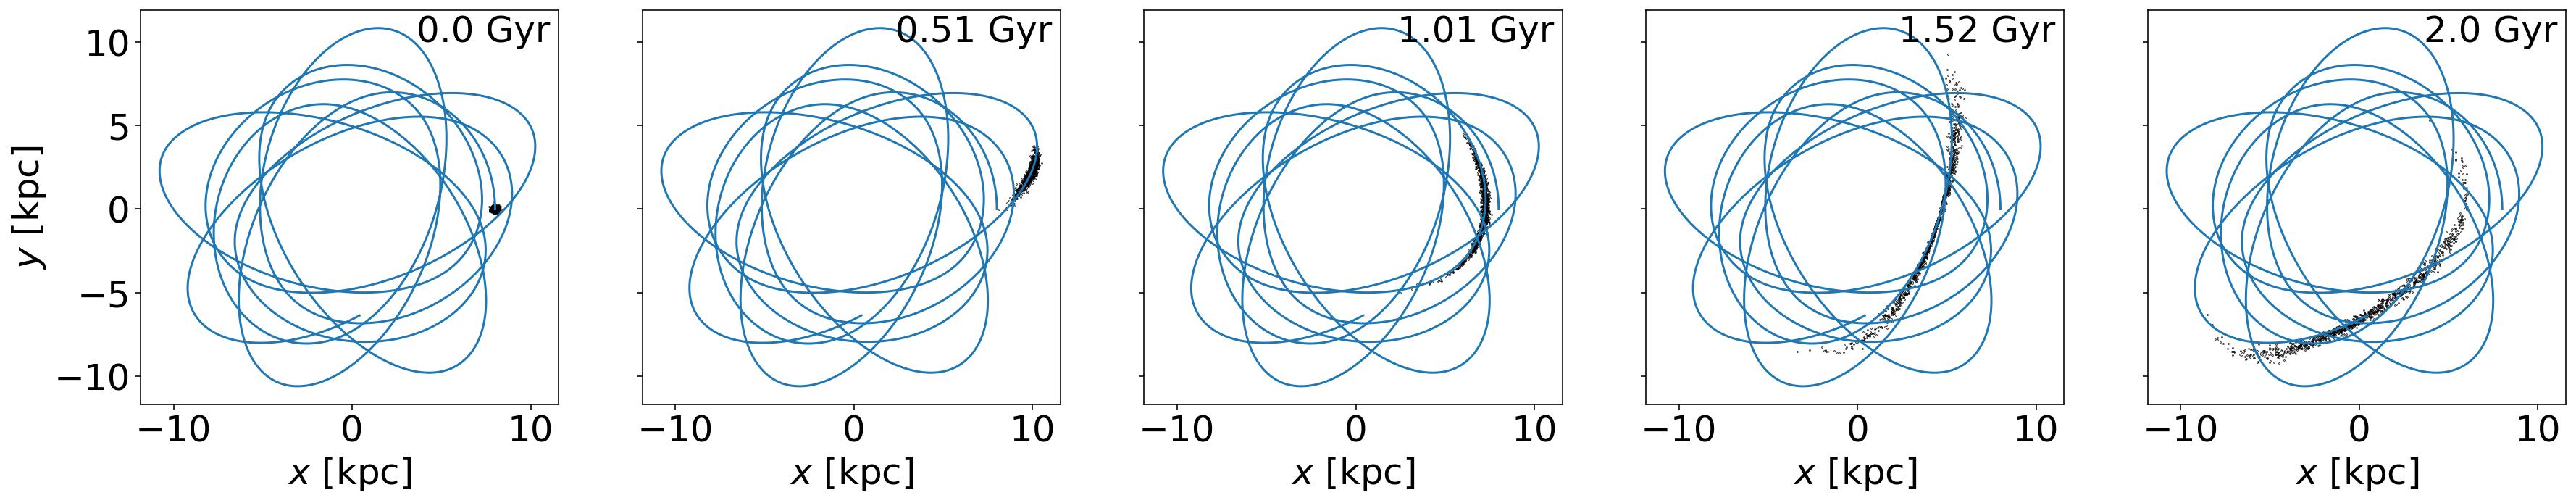

In [6]:
frames = np.arange(0, 5)*25
frames[-1] -=1

fig, axes = plt.subplots(ncols=5, figsize=(30,5), sharex=True, sharey=True)

text_args = dict(x = 0.98, y = 0.99,
                 va='top', ha='right', 
                 fontsize=25)
x,y,z = orbit_c.xyz

for (frame, ax) in zip(frames, axes):
    o, time = orbits[frame,:], orbits.t[frame]
    
    plt.text(s = time.to('Gyr').round(2), transform=ax.transAxes, **text_args)
    
    ax.scatter(o.x.to('kpc'), o.y.to('kpc'), s=0.1, c='k')    
    ax.plot(x,y)
    
    ax.set_xlabel('$x$ [kpc]')
axes[0].set_ylabel('$y$ [kpc]')

plt.show()

### Evolution of disance to centre of stream

In [7]:
Hamiltonian = gp.Hamiltonian(potential)

orbits = Hamiltonian.integrate_orbit(w0, 
                                     t = np.linspace(0,2,500)*u.Gyr, 
                                     Integrator=gi.DOPRI853Integrator)

In [8]:
# Distance between orbit 0 and orbit 1
dr = np.linalg.norm(orbits[:, 0].xyz - orbits[:, 1].xyz, axis=0)

Text(0.5, 0, 'time [Myr]')

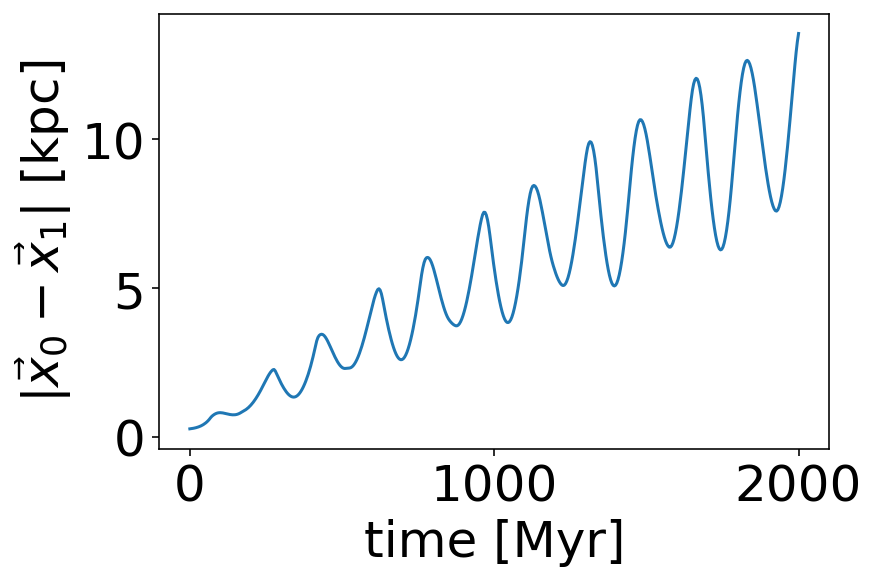

In [9]:
plt.plot(orbits.t, dr)
plt.ylabel(r'$|\vec{x}_0 - \vec{x}_1|$' +' [{}]'.format(dr.unit))
plt.xlabel('time [{}]'.format(orbits.t.unit))

### Bonus: 3D animations

In [10]:
# Click, drag, and zoom-in to inspect the orbit

from IPython.core.display import display, HTML
display(HTML(filename='./imgs/orbit-3d.html'))
# display(HTML(filename='./imgs/stream_animation.html'))
# display(HTML(filename='./imgs/stream_cats.html')) # Yes, those are cats.

In [11]:
%%script false --no-raise-error

# potential = gp.IsochronePotential(m=1e11*u.Msun, b=2*u.kpc, units=gala.units.galactic)
potential = gp.MilkyWayPotential(units = galactic)
Hamiltonian = gp.Hamiltonian(potential)


w0 = gd.PhaseSpacePosition(pos=[8, 0, 0]*u.kpc, # xyz
                           vel=[50, 200, 100]*u.km/u.s)  # v_xyz

orbit = Hamiltonian.integrate_orbit(w0, dt=1.*u.Myr, 
                                    n_steps=10_000, 
                                    Integrator=gi.LeapfrogIntegrator) # default


In [12]:
%%script false --no-raise-error

import ipyvolume as ipv

fig = ipv.figure(width=500, height=500)
ipv.plot(*orbit.xyz.value, color='gold')

ipv.xyzlim(-15,15)
ipv.xlabel('x [kpc]')
ipv.ylabel('y [kpc]')
ipv.zlabel('z [kpc]')

ipv.style.use('dark')
# ipv.save('./imgs/orbit-3d.html')
ipv.show()

In [13]:
%%script false --no-raise-error

import ipyvolume.datasets
stream = ipyvolume.datasets.animated_stream.fetch()
print("shape of steam data", stream.data.shape) # first dimension contains x, y, z, vx, vy, vz, then time, then particle

In [14]:
%%script false --no-raise-error

orbits = Hamiltonian.integrate_orbit(w0, 
                                     t = np.linspace(0,2,1000)*u.Gyr, 
                                     Integrator=gi.DOPRI853Integrator)

In [15]:
%%script false --no-raise-error

fig = ipv.figure()

q = ipv.scatter(*orbits.xyz.value, color="red", size=2, marker='circle_2d')
# q = ipv.quiver(*orbits.xyz.value[:,:,:100], *orbits.v_xyz.value[:,:,:100], color="red", size=7, marker='cat')

ipv.plot(*orbits[:,0].xyz.value, color='gold')


ipv.style.use("dark") # looks better
ipv.animation_control(q, interval=20)
fig.animation = 2.0

# ipv.save('./imgs/stream_animation.html')
ipv.show()

In [16]:

%%script false --no-raise-error


import ipyvolume as ipv

fig = ipv.figure(width=500, height=500)
ipv.plot(*orbit.xyz.value, color='gold')

ipv.xyzlim(-15,15)
ipv.xlabel('x [kpc]')
ipv.ylabel('y [kpc]')
ipv.zlabel('z [kpc]')

ipv.style.use('dark')
# ipv.save('./imgs/orbit-3d.html')
ipv.show()